<a href="https://colab.research.google.com/github/g-sat/Face-emotion-Recognition/blob/main/Emotion_recognision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle;

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp /content/drive/MyDrive/Colab/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download aadityasinghal/facial-expression-dataset

Dataset URL: https://www.kaggle.com/datasets/aadityasinghal/facial-expression-dataset
License(s): DbCL-1.0


In [ ]:
!unzip "/content/facial-expression-dataset.zip" -d "/content/facial-expression-dataset";

Streaming output truncated to the last 5000 lines.
  inflating: /content/facial-expression-dataset/train/train/sad/Training_65242339.jpg  
  inflating: /content/facial-expression-dataset/train/train/sad/Training_65267116.jpg  
  inflating: /content/facial-expression-dataset/train/train/sad/Training_65275626.jpg  
  inflating: /content/facial-expression-dataset/train/train/sad/Training_6529266.jpg  
  inflating: /content/facial-expression-dataset/train/train/sad/Training_65329617.jpg  
  inflating: /content/facial-expression-dataset/train/train/sad/Training_65338712.jpg  
  inflating: /content/facial-expression-dataset/train/train/sad/Training_65338797.jpg  
  inflating: /content/facial-expression-dataset/train/train/sad/Training_65387162.jpg  
  inflating: /content/facial-expression-dataset/train/train/sad/Training_65404494.jpg  
  inflating: /content/facial-expression-dataset/train/train/sad/Training_65426218.jpg  
  inflating: /content/facial-expression-dataset/train/train/sad/Traini

In [ ]:
!pip install tensorflow
!pip install opencv-python
!pip install seaborn
!pip install matplotlib
!pip install pandas
!pip install tqdm


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization,GlobalMaxPool2D,Activation,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras import Model
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import optimizers
import numpy as np
import pandas as pd
import cv2
import os
from sklearn.metrics import confusion_matrix
import itertools
print("Tensorflow version:", tf.__version__)


Tensorflow version: 2.18.0


In [ ]:
# Setup paths
train_path = "/content/facial-expression-dataset/train/train"
val_path = "/content/facial-expression-dataset/test/test"


In [ ]:
# data categories
categories = os.listdir(train_path)
print(categories)

['angry', 'disgust', 'sad', 'surprise', 'happy', 'neutral', 'fear']


In [ ]:
# Training images
total_train_images = 0
for dir_ in os.listdir(train_path):
    count = 0
    for f in os.listdir(train_path+'/' + dir_+"/"):
        count += 1
        total_train_images += 1
    print(f"{dir_} has {count} number of images")

print(f"\ntotal train images are {total_train_images}")

angry has 3995 number of images
disgust has 436 number of images
sad has 4830 number of images
surprise has 3171 number of images
happy has 7215 number of images
neutral has 4965 number of images
fear has 4097 number of images

total train images are 28709


In [ ]:
# Validation Images
total_validation_images = 0
for dir_ in os.listdir(val_path):
    count = 0
    for f in os.listdir(val_path+'/' + dir_+"/"):
        count += 1
        total_validation_images += 1
    print(f"{dir_} has {count} number of images")

print(f"\ntotal validation images are {total_validation_images}")

happy has 1774 number of images
neutral has 1233 number of images
disgust has 111 number of images
surprise has 831 number of images
sad has 1247 number of images
fear has 1024 number of images
angry has 958 number of images

total validation images are 7178


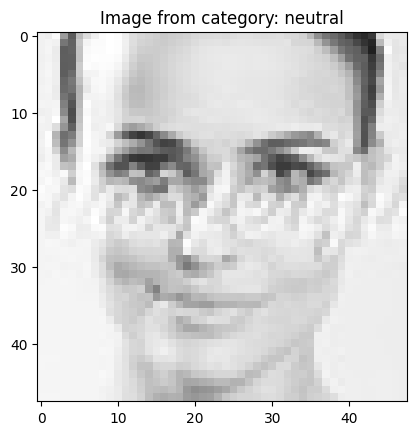

In [ ]:
#Showing some images from category neutral
import matplotlib.pyplot as plt
import os
import cv2

def imageshow(category):
    """Displays an image from the specified category."""

    # Get the path to the category directory
    category_path = os.path.join(train_path, category)

    # Check if the directory exists
    if os.path.exists(category_path):
        # Get a list of image files in the directory
        image_files = os.listdir(category_path)

        # Check if there are any images in the directory
        if image_files:
            # Get the path to the first image
            image_path = os.path.join(category_path, image_files[0])

            # Load the image using OpenCV
            img = cv2.imread(image_path)

            # Convert the image from BGR to RGB (OpenCV uses BGR by default)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Display the image using Matplotlib
            plt.imshow(img)
            plt.title(f"Image from category: {category}")
            plt.show()
        else:
            print(f"No images found in category: {category}")
    else:
        print(f"Category directory not found: {category}")

#Showing some images from category neutral
imageshow('neutral')

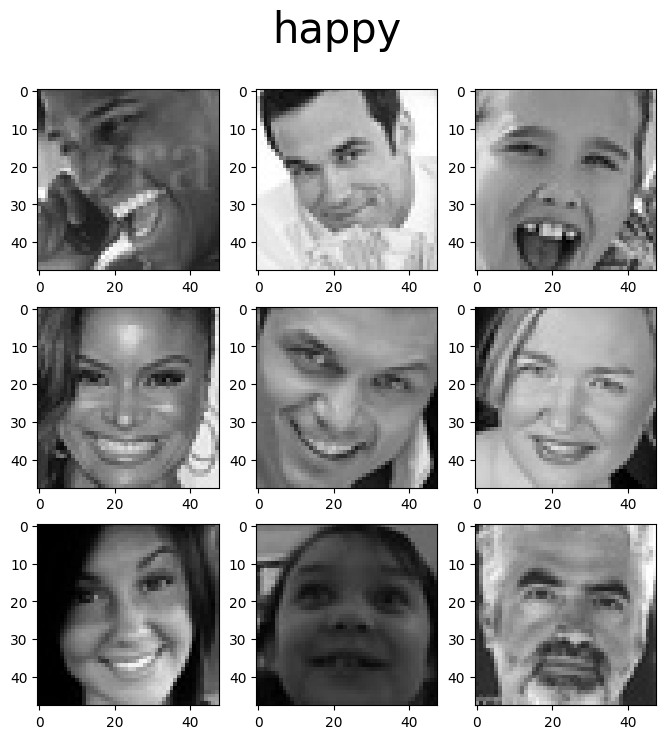

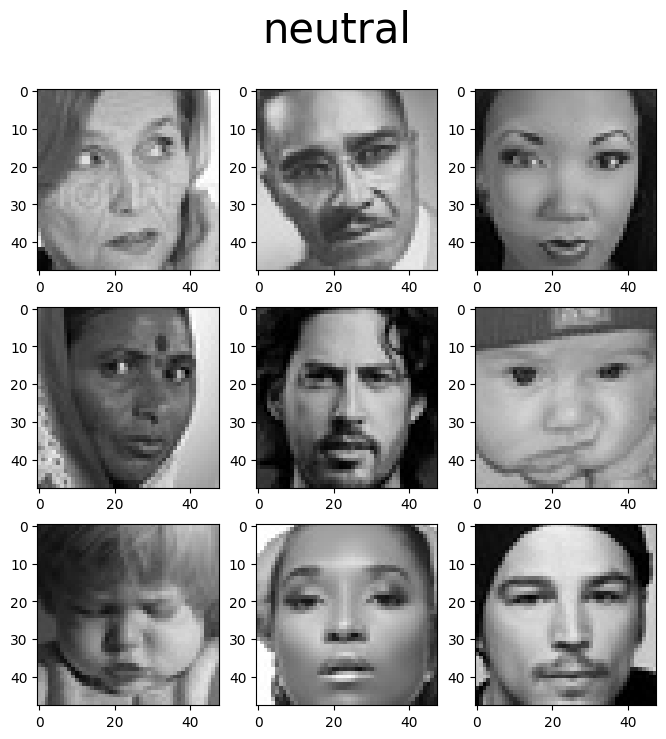

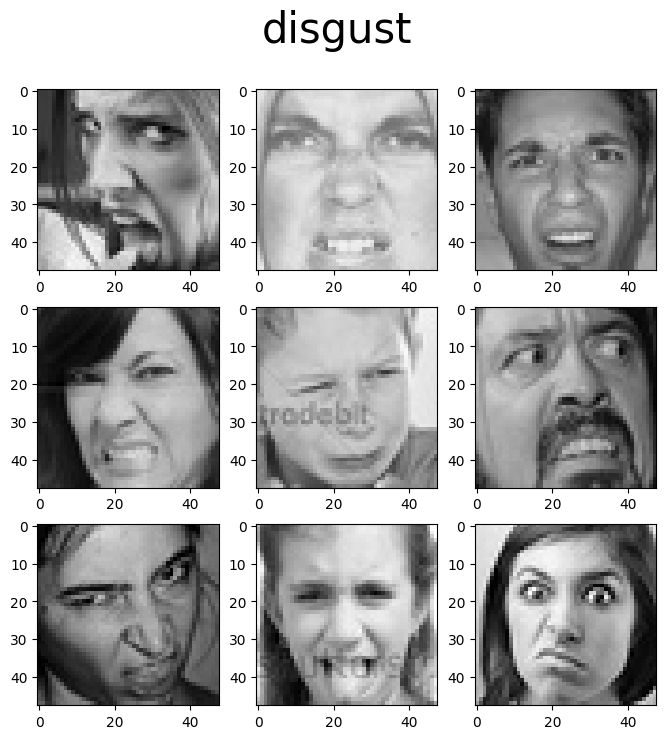

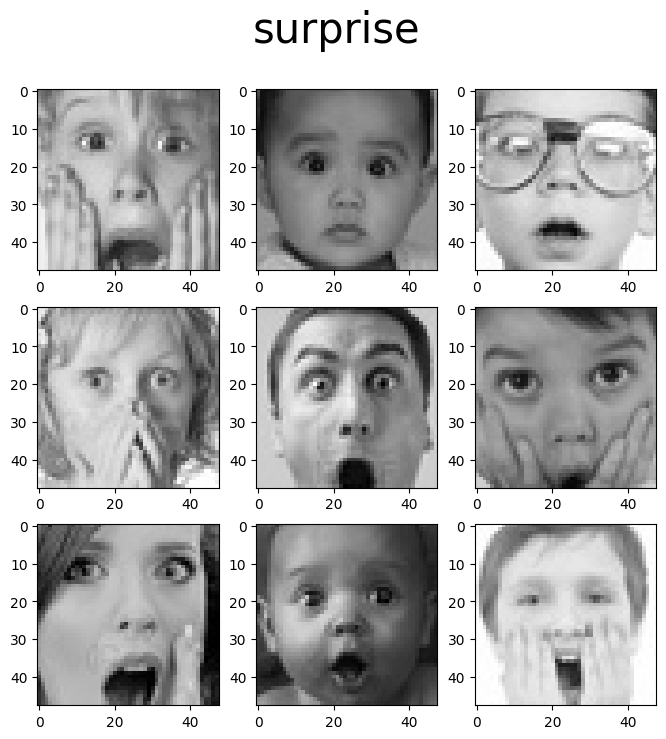

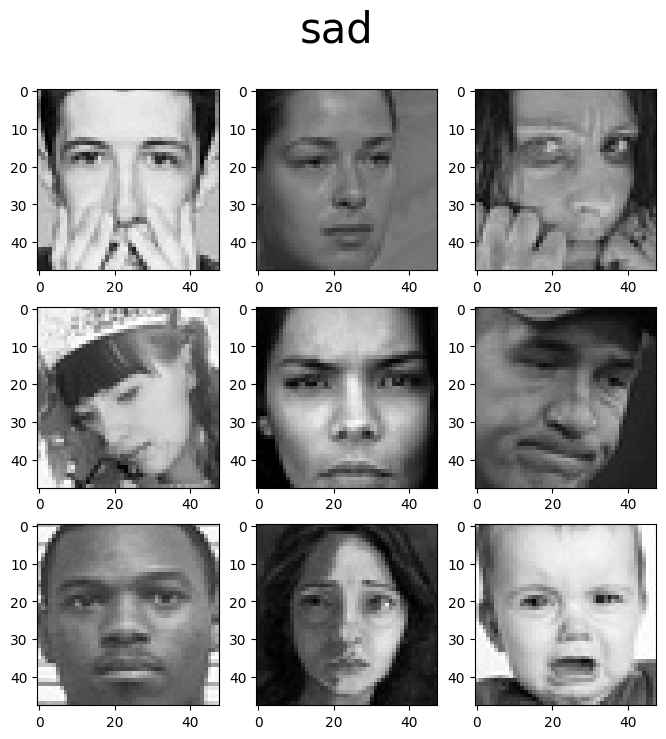

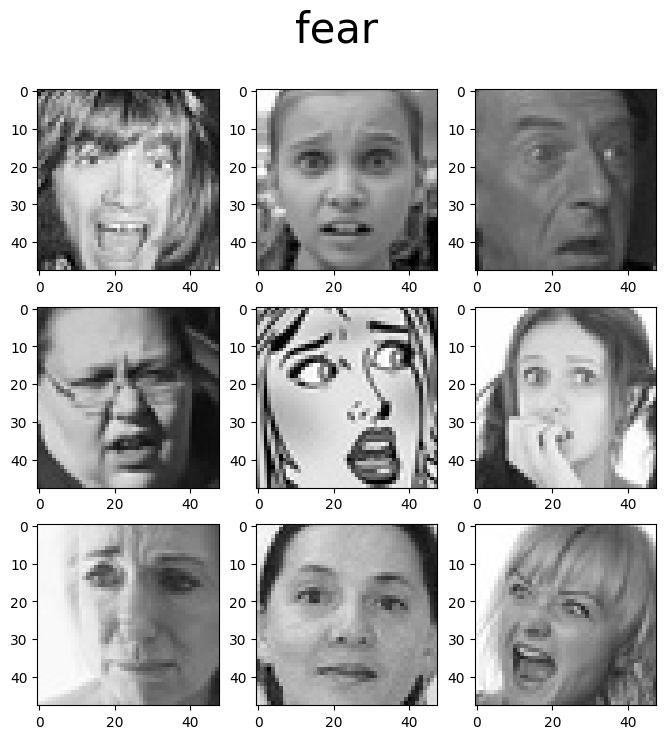

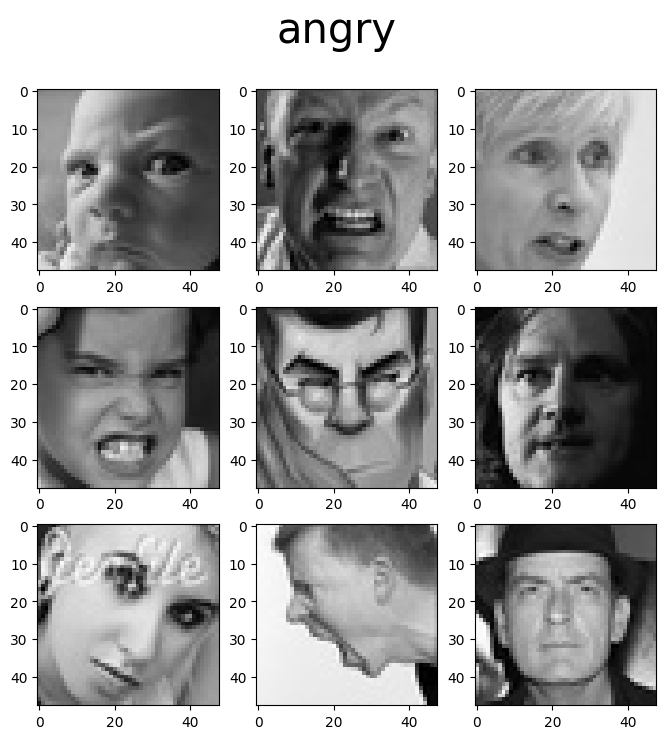

In [ ]:
# validation set images
for category in categories:
    plt.figure(figsize= (8,8))
    for j in range(1,10,1):

        plt.subplot(3,3,j)

        img = load_img(val_path+'/'+category+"/"+
                    os.listdir(val_path + "/" + category)[j], target_size=(48,48))
        plt.imshow(img)
    plt.suptitle(category,fontsize=30)
    plt.show()

In [ ]:
#resizing image size because ResNet50 model is trained on 224,224,3 images
img_size = 224
#Taking batch size
batch_size = 32

# selecting colour mode as rgb as transfer learning is trained on rgb photos and we have grascaled images
datagen_train = ImageDataGenerator(rescale=1./255)

# train generators
train_generator = datagen_train.flow_from_directory(train_path,
                                                  target_size=(img_size,img_size),
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  color_mode='rgb',
                                                  class_mode='categorical')

datagen_validation = ImageDataGenerator(rescale=1./255)

# validation generators
validation_generator = datagen_validation.flow_from_directory(val_path,
                                                  target_size=(img_size,img_size),
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  color_mode='rgb',
                                                  class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [ ]:
# creating a base model using ResNet50 and loading the pretrained weights
resnet = ResNet50(input_shape=(224,224,3), weights='imagenet', include_top=False)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# making all the layers except last 4 layers non trainable
for layer in resnet.layers:
  layer.trainable = False

In [ ]:
x = Flatten()(resnet.output)
prediction = Dense(7, activation='softmax')(x)

In [ ]:
model = Model(inputs=resnet.input, outputs=prediction)

In [ ]:
# compiling the model
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
#model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,290,183 (92.66 MB)

 Trainable params: 702,471 (2.68 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
epochs=150
steps_per_epoch=train_generator.n//train_generator.batch_size
steps_per_epoch

897

In [ ]:
# this decreases the learning rate if the model loss does not decrease
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=10, min_lr=0.00001, mode='auto')
# to save model weights
# filename changed to end with .weights.h5
checkpoint = ModelCheckpoint("/cotent/vgg16_weights.weights.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)
# to early stop
early_stopping=EarlyStopping(monitor='val_loss',
                            min_delta=0,
                            patience=10,
                            verbose=1,
                            restore_best_weights=True)
callbacks = [checkpoint, reduce_lr,early_stopping]

In [ ]:
history = model.fit(
    x=train_generator,
    batch_size=batch_size,
    epochs=epochs,
    validation_data = validation_generator,
    callbacks=callbacks,
    verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/150
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.2266 - loss: 3.0018
Epoch 1: saving model to /cotent/vgg16_weights.weights.h5
898/898 ━━━━━━━━━━━━━━━━━━━━ 119s 117ms/step - accuracy: 0.2267 - loss: 3.0012 - val_accuracy: 0.2544 - val_loss: 2.1438 - learning_rate: 0.0010
Epoch 2/150
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.2983 - loss: 2.1971
Epoch 2: saving model to /cotent/vgg16_weights.weights.h5
898/898 ━━━━━━━━━━━━━━━━━━━━ 94s 105ms/step - accuracy: 0.2983 - loss: 2.1970 - val_accuracy: 0.3153 - val_loss: 1.8861 - learning_rate: 0.0010
Epoch 3/150
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.3339 - loss: 2.0815
Epoch 3: saving model to /cotent/vgg16_weights.weights.h5
898/898 ━━━━━━━━━━━━━━━━━━━━ 94s 105ms/step - accuracy: 0.3339 - loss: 2.0816 - val_accuracy: 0.3429 - val_loss: 2.3465 - learning_rate: 0.0010
Epoch 4/150
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.3523 - loss: 2.0836
Epoch 4: saving model to /cotent/vgg16_we

#Data generation for Custom CNN model

In [ ]:
# image size
img_size = 48

# number of images to feed into the NN for every batch
batch_size = 64

# data augmentation for training set
datagen_train = ImageDataGenerator(horizontal_flip=True, # fliping the images
                                   brightness_range=[0.8,1.2],
                                   rescale=1./255) # scale the data

# Training data generator
train_data = datagen_train.flow_from_directory(train_path, #path of training images
                                                  target_size=(img_size,img_size), # image size are 48*48 pixels
                                                  batch_size=batch_size, # we are taking 32 batch size
                                                  shuffle=True, # shuffling the images
                                                  color_mode='grayscale', # because all images are grayscale
                                                  class_mode='categorical') #we have 7 categories

# data augmentation for validation set
datagen_validation = ImageDataGenerator(rescale=1./255)

# Validation data generator
validation_data = datagen_validation.flow_from_directory(val_path, # path of validation images
                                                  target_size=(img_size,img_size), # images size are 48*48 pixels
                                                  batch_size=batch_size, # we are taking 32 batch size
                                                  shuffle=False, # not shuffle the images
                                                  color_mode='grayscale', # because all images are grayscale
                                                  class_mode='categorical') #we have 7 categories

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
num_classes = 7
model = Sequential()
#the 1-st block
model.add(Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_1',input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_2'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), name = 'pool1_1'))
model.add(Dropout(0.3, name = 'drop1_1'))#the 2-nd block
model.add(Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_1'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_2'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_3'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), name = 'pool2_1'))
model.add(Dropout(0.3, name = 'drop2_1'))#the 3-rd block
model.add(Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_1'))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_2'))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_3'))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_4'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), name = 'pool3_1'))
model.add(Dropout(0.3, name = 'drop3_1'))#the 4-th block
model.add(Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_1'))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_2'))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_3'))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_4'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), name = 'pool4_1'))
model.add(Dropout(0.3, name = 'drop4_1'))

#Flatten and output
model.add(Flatten(name = 'flatten'))

#Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax', name = 'output'))# create model


# compiling the model
opt = Adam(learning_rate=0.0007)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1_1 (Conv2D)                │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_2 (Conv2D)                │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1_1 (MaxPooling2D)          │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1_1 (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_1 (Conv2D)                │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_2 (Conv2D)                │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_3 (Conv2D)                │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2_1 (MaxPooling2D)          │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2_1 (Dropout)               │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_1 (Conv2D)                │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_2 (Conv2D)                │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_3 (Conv2D)                │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_4 (Conv2D)                │ (None, 12, 12, 256)    │       590,08

 Total params: 5,570,887 (21.25 MB)

 Trainable params: 5,564,231 (21.23 MB)

 Non-trainable params: 6,656 (26.00 KB)

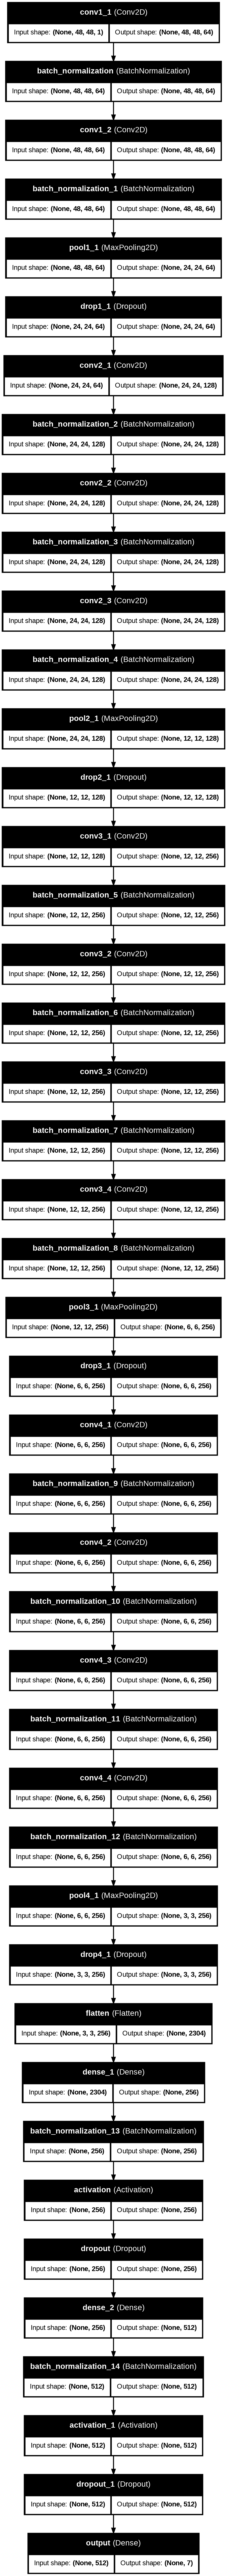

In [ ]:
# save model details in png format
utils.plot_model(model, to_file='emotion-model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# defining steps per epochs
epochs=150
steps_per_epoch=train_data.n//train_data.batch_size
print("Training steps per epochs",steps_per_epoch)

validation_steps=validation_data.n//validation_data.batch_size
print("Validation steps per epochs",validation_steps)

Training steps per epochs 448
Validation steps per epochs 112


In [ ]:
"""
I used three callbacks
one is `early stopping` for avoiding overfitting training data
2nd is 'checkpoint' to save model weights and
other `ReduceLROnPlateau` for reducing learning rate.
"""

#this decreases the learning rate if the model loss does not decrease
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.0001, mode='auto')

# to save model weights
# changed file name to end with `.weights.h5` to avoid ValueError
checkpoint = ModelCheckpoint("model_weights.weights.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)

# for avoiding overfitting training data
early_stopping=EarlyStopping(monitor='val_loss',
                            min_delta=0,
                            patience=5,
                            verbose=1,
                            restore_best_weights=True)

callbacks = [checkpoint, reduce_lr, early_stopping]

In [ ]:
# fitting the model
history = model.fit(
    x=train_data,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_data,
    validation_steps = validation_steps,
    callbacks=callbacks,
    verbose=1)

Epoch 1/150


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.2131 - loss: 2.0135
Epoch 1: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 69s 99ms/step - accuracy: 0.2132 - loss: 2.0133 - val_accuracy: 0.2706 - val_loss: 1.7528 - learning_rate: 7.0000e-04
Epoch 2/150
  1/448 ━━━━━━━━━━━━━━━━━━━━ 26s 59ms/step - accuracy: 0.3438 - loss: 1.7376

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3438 - loss: 1.7376 - val_accuracy: 0.3040 - val_loss: 1.7168 - learning_rate: 7.0000e-04
Epoch 3/150
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.3771 - loss: 1.6212
Epoch 3: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 53s 70ms/step - accuracy: 0.3771 - loss: 1.6211 - val_accuracy: 0.4441 - val_loss: 1.4516 - learning_rate: 7.0000e-04
Epoch 4/150
  1/448 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy: 0.4219 - loss: 1.5043
Epoch 4: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4219 - loss: 1.5043 - val_accuracy: 0.4470 - val_loss: 1.4360 - learning_rate: 7.0000e-04
Epoch 5/150
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.4761 - loss: 1.3784
Epoch 5: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 38s 70ms/step - accuracy: 0.4761 - loss: 1.3783 - val_accuracy: 0.51

In [ ]:
# Save the entire model
model.save('/content/CNN_Model_emotion.h5')

# loading the model
model_emo = load_model('/content/CNN_Model_emotion.h5')


In [ ]:
# Assuming 'history' is the object returned by model.fit()
import pandas as pd

# Convert the history object to a DataFrame
history_df = pd.DataFrame(history.history)

# Save the DataFrame to a CSV file
history_df.to_csv('/content/history.csv', index=False)

# Read the data back from the CSV (optional)
history_df = pd.read_csv("/content/history.csv")

NameError: name 'history' is not defined

In [ ]:
# load the CNN model
model_emo = load_model('/content/CNN_Model_emotion.h5')

# predict on the validation data
predictions = model_emo.predict(validation_data)

# save the predictions to a file
np.save("/content/predictions.npy", predictions)

# load the saved predictions
predictions = np.load("/content/predictions.npy")

NameError: name 'load_model' is not defined

In [ ]:
accuracy=accuracy_score(y_pred=np.argmax(predictions, axis=-1),y_true=validation_data.classes)
print(accuracy)

0.6592365561437726


In [ ]:
history_df.head()

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.243044,1.902219,0.270647,1.752823,0.0007
1,0.343750,1.737644,0.303990,1.716800,0.0007
2,0.415500,1.536528,0.444057,1.451643,0.0007
3,0.421875,1.504287,0.446987,1.436018,0.0007
4,0.489265,1.342830,0.513532,1.367395,0.0007


<Figure size 640x480 with 0 Axes>

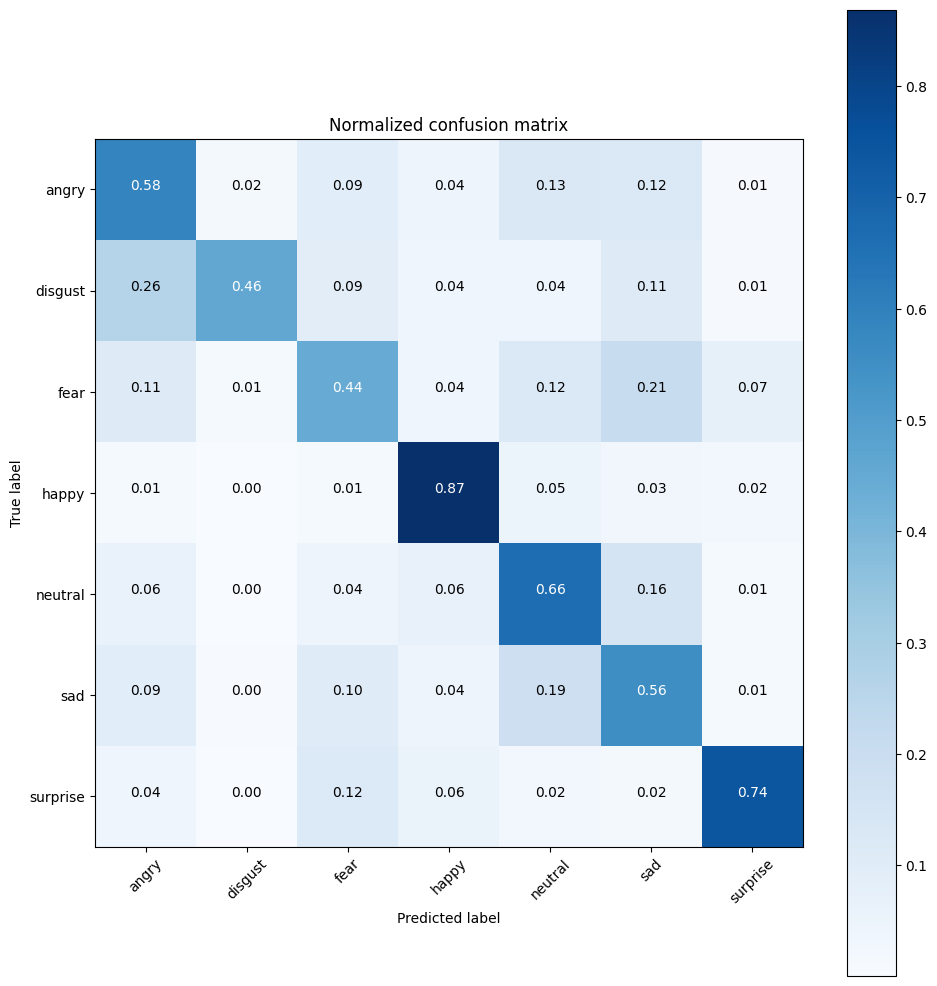

In [ ]:
# show the confusion matrix of our predictions

# compute predictions

y_pred = [np.argmax(probas) for probas in predictions]
y_test = validation_data.classes
class_names = validation_data.class_indices.keys()


def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')# **Live Class Monitoring System(Face Emotion Recognition)**
    plt.xlabel('Predicted label')
    plt.tight_layout()

# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers

# Load the trained model
model = load_model('/content/CNN_Model_emotion.h5')

# Re-compile the model with the original optimizer and loss
# Assuming you used 'adam' optimizer and 'categorical_crossentropy' loss during training
opt = optimizers.Adam(learning_rate=0.0007)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Define the labels for emotions
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Initialize the camera
cap = cv2.VideoCapture(0)

# Create a Matplotlib figure
plt.figure()

try:
    while True:
        # Capture frame-by-frame
        ret, frame = cap.read()

        if not ret:
            break

        # Resize the frame to match the input size of the model
        resized_frame = cv2.resize(frame, (48, 48), interpolation=cv2.INTER_AREA)

        # Convert the frame to grayscale
        gray_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2GRAY)

        # Reshape the grayscale image to match the model's input shape
        input_image = np.expand_dims(np.expand_dims(gray_frame, -1), 0)
        input_image = input_image / 255.0  # Normalize pixel values

        # Make a prediction
        prediction = model.predict(input_image)
        predicted_emotion = emotion_labels[np.argmax(prediction)]

        # Display the predicted emotion on the frame
        cv2.putText(frame, predicted_emotion, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Display the resulting frame using Matplotlib
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for Matplotlib
        plt.title('Live Face Emotion Detection')
        plt.pause(0.1)  # Pause to update the display
        plt.clf()  # Clear the figure for the next frame

        # Exit on pressing 'q'
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
except KeyboardInterrupt:
    pass
finally:
    # When everything done, release the capture
    cap.release()
    # Close the Matplotlib figure
    plt.close()

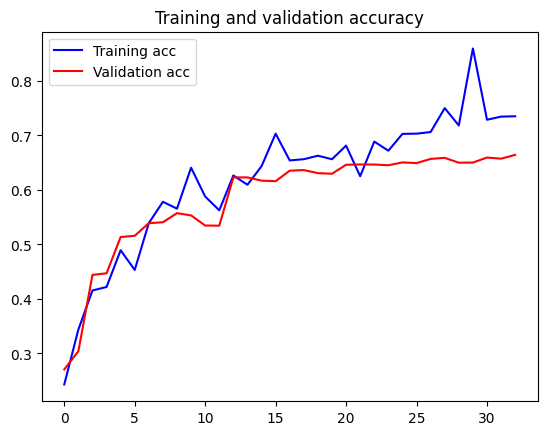

<Figure size 640x480 with 0 Axes>

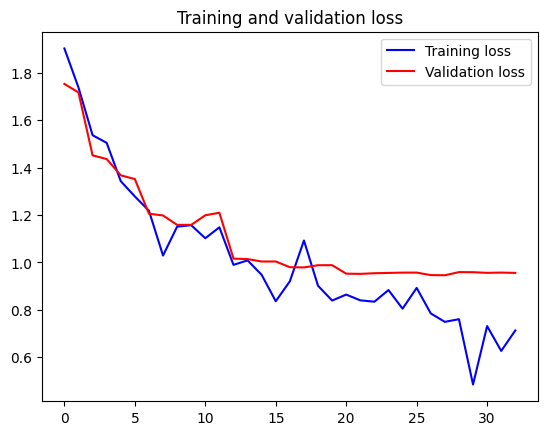

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.show()
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
import cv2
cap = cv2.VideoCapture(0)

In [ ]:
model.save('/content/CNN_Model_emotion.h5')

In [ ]:
from tensorflow.keras.models import load_model

# Load your trained emotion detection model
model = load_model('/content/CNN_Model_emotion.h5', compile=False)  # Load without compiling

# Compile the model with required settings
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
!pip install opencv-python-headless

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import base64
from google.colab import output
from IPython.display import display, HTML
from keras.models import load_model
from keras.preprocessing.image import img_to_array

# Load your emotion detection model
model = load_model('/content/CNN_Model_emotion.h5',compile=False)  # Replace with your model path

# Define a function to predict emotion
def predict_emotion(face_image):
    face_image = cv2.resize(face_image, (48, 48))  # Resize to model input size
    face_image = cv2.cvtColor(face_image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    face_image = face_image / 255.0  # Normalize
    face_image = img_to_array(face_image)  # Convert to array
    face_image = np.expand_dims(face_image, axis=0)  # Expand dimensions to match model input
    prediction = model.predict(face_image)
    emotion_label = np.argmax(prediction)  # Get the index of the highest score
    return emotion_label

# Define a function to capture an image from the webcam
def capture_image():
    video_html = """
    <video autoplay style="width: 100%;"></video>
    <script>
    const video = document.querySelector("video");
    navigator.mediaDevices.getUserMedia({ video: true })
      .then(stream => {
        video.srcObject = stream;
        video.play();
      });
    </script>
    """

    # Display the video stream
    display(HTML(video_html))

    # Use JavaScript to create a button to capture the image
    button_html = """
    <button id="capture">Capture Image</button>
    <canvas id="canvas" style="display:none;"></canvas>
    <script>
    const button = document.getElementById("capture");
    const video = document.querySelector("video");
    const canvas = document.getElementById("canvas");

    button.addEventListener("click", () => {
        const context = canvas.getContext("2d");
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        context.drawImage(video, 0, 0, canvas.width, canvas.height);
        const data = canvas.toDataURL("image/png");
        google.colab.kernel.invokeFunction('capture_image', [data], {});
    });
    </script>
    """

    # Display the capture button
    display(HTML(button_html))

# Create a function to receive the captured image data and display emotion
def save_image(data):
    # Process the image data
    image_data = data.split(',')[1]
    image_data = base64.b64decode(image_data)
    img = np.frombuffer(image_data, np.uint8)

    # Decode the image array
    img = cv2.imdecode(img, cv2.IMREAD_COLOR)

    # Check if the image was processed correctly
    if img is not None:
        # Convert BGR to RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Predict the emotion
        emotion_label = predict_emotion(img)

        # Map numerical label to emotion name
        emotion_names = {0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"}
        label = emotion_names.get(emotion_label, "Unknown")

        # Display the captured image and predicted emotion using matplotlib
        plt.imshow(img_rgb)
        plt.title(f'Predicted Emotion: {label}')
        plt.axis('off')  # Hide axes
        plt.show()
    else:
        print("Error: Could not decode the image.")

# Register the image capturing function
output.register_callback('capture_image', save_image)

# Start capturing images
capture_image()

In [ ]:
# Example: Evaluating the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # compile model here

results = model.evaluate(x_test, y_test)
print(f"Evaluation Results: {results}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.6042 - loss: 1.1530
Evaluation Results: [1.1396690607070923, 0.609375]


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=SparseCategoricalCrossentropy(),
    metrics=[SparseCategoricalAccuracy()]
)

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/CNN_Model_emotion.h5', compile=False)

In [ ]:
import os
import base64
import cv2
import numpy as np
from google.colab import output

def save_image(image_data, full_file_path):
    try:
        # Decode the base64-encoded image data
        binary = base64.b64decode(image_data)
        # Convert binary data to a NumPy array
        image_array = cv2.imdecode(np.frombuffer(binary, dtype=np.uint8), cv2.IMREAD_COLOR)
        # Save the image to the specified path
        cv2.imwrite(full_file_path, image_array)
        return True
    except Exception as e:
        print(f"Error saving image: {e}")
        return False

# Register the callback function
output.register_callback('notebook.save_image', save_image)

In [ ]:
from IPython.display import display, Javascript

def take_photo(filename='/content/photo.jpg', quality=0.8):
    js_code = f"""
    async function takePhoto() {{
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = 'Capture';
        div.appendChild(capture);

        const video = document.createElement('video');
        video.style.display = 'block';
        document.body.appendChild(div);
        div.appendChild(video);

        const stream = await navigator.mediaDevices.getUserMedia({{video: true}});
        video.srcObject = stream;
        await video.play();

        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

        capture.onclick = async () => {{
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getTracks().forEach(track => track.stop());
            div.remove();

            const imageData = canvas.toDataURL('image/jpeg', {quality}).split(',')[1];
            const is_saved = await google.colab.kernel.invokeFunction(
                'notebook.save_image', [imageData, '{filename}'], {{}}
            );
            console.log(is_saved);
        }};
    }}

    takePhoto();
    """
    display(Javascript(js_code))

In [ ]:
try:
    filename = '/content/photo.jpg'
    take_photo(filename=filename)
    print(f"Saved photo to {filename}")
except Exception as e:
    print(f"Error: {e}")

<IPython.core.display.Javascript object>

Saved photo to /content/photo.jpg


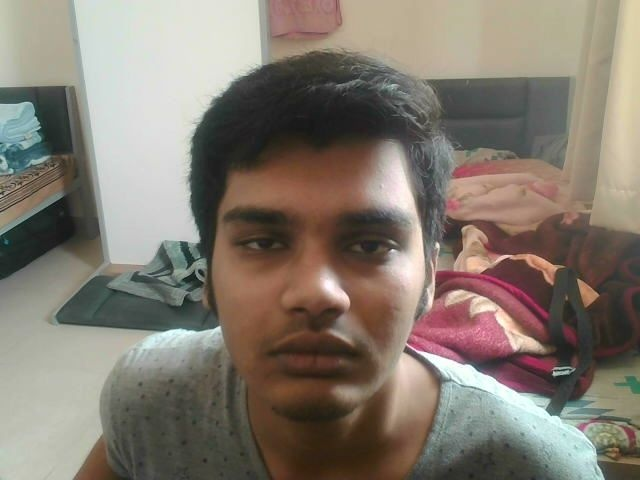

In [ ]:
from IPython.display import Image, display

display(Image('/content/photo.jpg'))

In [ ]:
import cv2
import numpy as np

def preprocess_image(image_path):
    # Load image using OpenCV
    img = cv2.imread(image_path)

    # Convert to grayscale (if required by your model)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Resize image to match input shape of your model (e.g., 48x48 for FER2013 dataset)
    resized_img = cv2.resize(gray_img, (48, 48))

    # Normalize pixel values (0-255 to 0-1)
    normalized_img = resized_img / 255.0

    # Reshape to add batch dimension and channel dimension (if needed)
    processed_img = normalized_img.reshape(1, 48, 48, 1)

    return processed_img

# Preprocess the saved photo
processed_image = preprocess_image('/content/photo.jpg')

In [ ]:
# Define emotion labels (adjust based on your dataset's labels)
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Predict emotion
predictions = model.predict(processed_image)

# Get the index of the highest confidence score
emotion_index = np.argmax(predictions)

# Map index to emotion label
detected_emotion = emotion_labels[emotion_index]

print(f"Detected Emotion: {detected_emotion}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Detected Emotion: Surprise


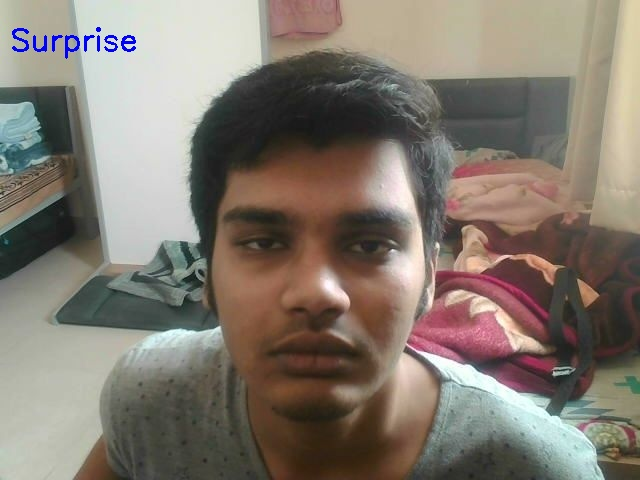

In [ ]:
def annotate_image(image_path, emotion):
    img = cv2.imread(image_path)

    # Add text annotation for detected emotion
    cv2.putText(img, emotion, (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

    # Save annotated image
    annotated_path = '/content/annotated_photo.jpg'
    cv2.imwrite(annotated_path, img)

    return annotated_path

annotated_image_path = annotate_image('/content/photo.jpg', detected_emotion)

# Display annotated image in Colab
from IPython.display import Image, display
display(Image(annotated_image_path))

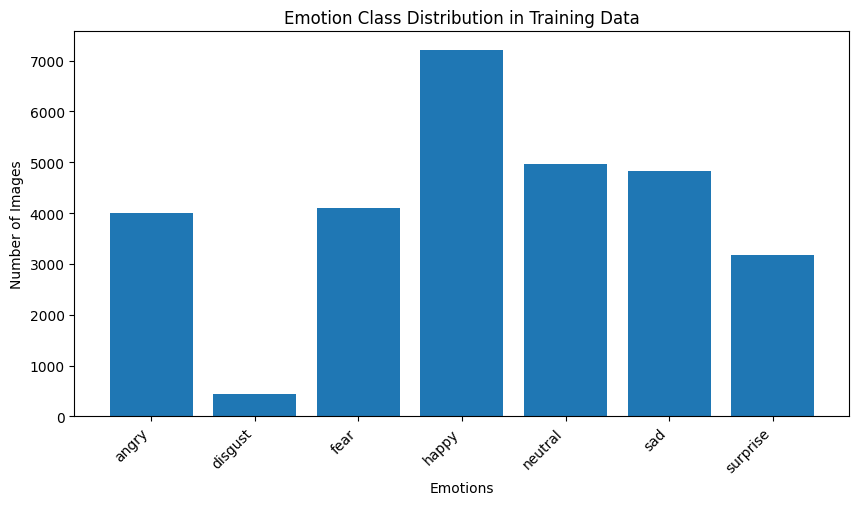

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'train_data' is your training data generator from previous code
class_counts = train_data.classes.tolist()  # Get class labels
emotion_names = list(train_data.class_indices.keys())  # Get emotion names

# Calculate the frequency of each emotion
unique, counts = np.unique(class_counts, return_counts=True)
emotion_counts = dict(zip(unique, counts))

# Create a list of counts corresponding to the emotion_names
counts_for_plot = [emotion_counts.get(train_data.class_indices[emotion], 0) for emotion in emotion_names]

# Plot class distribution
plt.figure(figsize=(10, 5))
plt.bar(emotion_names, counts_for_plot)  # Use counts_for_plot here
plt.title('Emotion Class Distribution in Training Data')
plt.xlabel('Emotions')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

In [ ]:
import os
import random
from PIL import Image

def augment_images(source_dir, target_dir, num_needed):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    # Check if source directory exists
    if not os.path.exists(source_dir):
        print(f"Error: Source directory '{source_dir}' does not exist.")
        return  # Exit the function early

    images = os.listdir(source_dir)
    for i in range(num_needed):
        img_path = os.path.join(source_dir, random.choice(images))
        img = Image.open(img_path)

        # Example augmentation: rotate the image
        img = img.rotate(random.randint(-30, 30))

        # Save the augmented image
        img.save(os.path.join(target_dir, f'augmented_{i}.jpg'))

# Example usage
# Update the paths according to your actual directory structure
augment_images('/content/facial-expression-dataset/train/train/neutral', '/content/facial-expression-dataset/train/train/neutral_augmented', 1035)
augment_images('/content/facial-expression-dataset/train/train/disgust', '/content/facial-expression-dataset/train/train/disgust_augmented', 5564)
augment_images('/content/facial-expression-dataset/train/train/surprise', '/content/facial-expression-dataset/train/train/surprise_augmented', 2829)
augment_images('/content/facial-expression-dataset/train/train/sad', '/content/facial-expression-dataset/train/train/sad_augmented', 1170)
augment_images('/content/facial-expression-dataset/train/train/fear', '/content/facial-expression-dataset/train/train/fear_augmented', 1903)
augment_images('/content/facial-expression-dataset/train/train/angry', '/content/facial-expression-dataset/train/train/angry_augmented', 1005)

In [ ]:
import os

# Check if the 'dataset' directory exists, and create it if not
if not os.path.exists('dataset'):
    os.makedirs('dataset')

# Check if the 'neutral' directory exists within 'dataset', and create it if not
source_dir = 'dataset/neutral'
if not os.path.exists(source_dir):
    os.makedirs(source_dir)

# Now you can proceed with listing the directory contents
print(os.listdir(source_dir))

[]


In [ ]:
import os

def check_image_counts(base_dir):
    for emotion in os.listdir(base_dir):
        count = len(os.listdir(os.path.join(base_dir, emotion)))
        print(f"{emotion}: {count} images")

check_image_counts('dataset')

neutral_augmented: 0 images
neutral: 0 images
